# **Before you start**

1.   Go to "*File*" --> "*Save a copy in Drive*"
2.   Open that copy (might open automatically)
3.   Then continue below

---
---
---

# Machine Listening Seminar 3: Sound/Music classification with simple Neural Networks

* We need real data to work with, so we revisit the previous seminar and **race** through sections 1-8 here:
 * Curate a "ESC-5" dataset, generate features and targets
* Create simple neural networks
 * Keras / Tensorflow
 * Dense & Convolutional layers
 * Activations & Dropout
 * Training & Evaluation
* Compare evaluation scores of the different approaches



---

# 1. Import libraries

* We need a number of libraries. Import them once to use throughout the document.

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


# Tensorflow: check available devices
all_devices = tf.config.list_physical_devices()
print('Found {} devices: {}'.format( len(all_devices), all_devices ))

Expected output:
```
Found 1 devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
```



---

# 2. Fetch the Dataset

* ESC-50: a dataset for Environmental Sound Classification (https://github.com/karolpiczak/ESC-50, https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)
 * 50 classes, 40 files per class, 5s clips
* Download & unzip the dataset running the cell below.
 * In Google Colab, you will see the new files on the left (folder icon).

In [ ]:
!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
!unzip master.zip

---

# 3. Metadata and analysis

* Let's recollect our memory on the structure of ESC-50.

In [ ]:
fn_csv = 'ESC-50-master/meta/esc50.csv'

df = pd.read_csv(fn_csv)  # reads csv, creates dataframe
print(df.head())
unique_classes = df['category'].unique()  # retrieves a list of unique classes
print(f'\nUnique classes: {unique_classes}\nCount: {len(unique_classes)}')

Expected output:
```
    filename            fold  target  category        esc10   src_file  take
0   1-100032-A-0.wav    1     0       dog             True    100032    A
1   1-100038-A-14.wav   1     14      chirping_birds  False   100038    A
2   1-100210-A-36.wav   1     36      vacuum_cleaner  False   100210    A
3   1-100210-B-36.wav   1     36      vacuum_cleaner  False   100210    B
4   1-101296-A-19.wav   1     19      thunderstorm    False   101296    A

Unique classes: ['dog' 'chirping_birds' 'vacuum_cleaner' ... ]
Count: 50
```


---

# 4. ESC-5: Curation

Let's select 5 classes (*our_classes*) from ESC-50 to make things a bit faster.

***Tasks:***
* Collect all files that belong to *our_classes*.
* Put the files and their respective classes in separate lists. Make sure their indices are equal (meaning: the value at index 3 of list *A* is related to the value at index 3 of list *B*).
  * Idea 1: Use *df.values* to iterate over the rows of the csv
  * Idea 2: Use *df.query('category in @our_classes')*
* Print the first 5 elements of each list as (file, class)-tuples. Also, print the overall lengths of the lists.

In [ ]:
our_classes = ["crying_baby", "dog", "rain", "rooster", "sneezing"]  # Note: This is also our class map for later.
esc5_X = []  # File list
esc5_y = []  # Class list
fn_csv = "ESC-50-master/meta/esc50.csv"


### START CODING HERE ###
df = pd...

for row in df.values:  # (This particular algorithm here works, but is not ideal)
  if any(... == ... for ... in our_classes):
    esc5_X.append( ... )  # Filename column
    ....append( ... )  # Class column

print( list(zip(esc5_X[:5], esc5_y[:5])) )
print(f"Lengths: esc5_X: {...}, esc5_y: {...}")
### END CODING HERE ###

Expected output:
```
[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-17367-A-10.wav', 'rain'), ('1-187207-A-20.wav', 'crying_baby'), ('1-211527-A-20.wav', 'crying_baby')]
Lengths: esc5_X: 200, esc5_y: 200
```



---

# 5. Splitting the dataset into *train* and *test* subsets

***Tasks:***
* ESC-5 is almost ready. With **sklearn**, split the dataset into **train** and **test** subsets with a 80%/20% split ratio and random state 1337.
* Print the first 3 elements of the resulting *X_train*.
* Print the overall lengths of the resulting lists. Are they aligned with the ratio?

In [ ]:
### START CODING HERE ###
X_train, X_test, y_train, ... = ...(esc5_X, ..., test_size=..., random_state=...)  # Look at your imports for a hint which function to use.

print(X_train...)
print(f"X: {...}, {...}; y: {...}, {...}")
### END CODING HERE ###

Expected output:
```
['5-203128-A-0.wav', '4-181286-A-10.wav', '3-157615-A-10.wav']
X: 160, 40; y: 160, 40
```

---
# 6. ESC-5: Create mel spectrograms

We need to compute features and corresponding labels for each file in our ESC-5.

***Tasks:***
* Define a function that does the following (in this order!):
  * takes input parameters: *X_train* (list of filenames), *y_train* (list of classes)
  * loops over *X_train* (hint: *enumerate* it), and loads each file (.wav) using **librosa**
  * creates the mel spectrogram from the loaded .wav samples
  * normalizes the mel spec by dividing it through the number of given *mel_bands*.
  * transposes the mel spec
  * appends the features (mel spec) to a feature tensor
  * creates a target vector consisting of as many values as there are frames
    * hint: use *.shape* to see which value you need
  * each value inside the vector must correspond to the index of the class in *our_classes*
    * hint: remember *numpy.ones(...)* ?
    * hint: use *.index(...)* here. Not ideal, but works here.
  * appends the targets to a target tensor
  * stacks the large feature and target lists appropriately
  * returns the tensors
* Finally, print the shapes of all 4 arrays.

In [ ]:
### START CODING HERE ###
def extract_mel_spec(...):
  X = []  # feature tensor
  y = []  # target tensor

  mel_bands = 128
  for i, filename in tqdm(...(data_X)):  # tqdm displays a progress bar.
    wav_data, sr = ...(f"ESC-50-master/audio/{filename}")  # Use the wav file's sample rate.

    # Features
    mel_spec = librosa.feature.melspectrogram(y=wav_data, sr=sr, n_mels=mel_bands)  # Create mel spectrogram. Output shape: (128, 216) (n_mels, frames)
    mel_spec = mel_spec...  # Normalization
    mel_spec = mel_spec...  # Transposition. Output shape: (216, 128)
    X ... ( mel_spec )  # Append to feature tensor

    # Targets == class_name
    targets = np.ones( mel_spec.shape[0] )  # Create a PLACEHOLDER target vector. Output shape: (216) (Note: silent frames are NOT going to be labeled as "silent")
    targets = targets * our_classes.index( data_y[i] )  # Convert values to actual class-index from 'our_classes'
    ...  # Append to target tensor

  # Stack tensors
  X = np.vstack(X)
  y = np.hstack(y)

  # Return the tensors
  return X, y


# Call the function on our previously generated lists
X_train_ready, y_train_ready = ...(X_train, y_train)
X_test_ready, y_test_ready = extract_mel_spec(...)
### END CODING HERE ###


print(f"\nShapes: X_train_ready: {X_train_ready.shape}, y_train_ready: {y_train_ready.shape}")
print(f"Shapes: X_test_ready: {X_test_ready.shape}, y_test_ready: {y_test_ready.shape}")

Expected output:
```
Shapes: X_train_ready: (34560, 128), y_train_ready: (34560,)
Shapes: X_test_ready: (8640, 128), y_test_ready: (8640,)
```



---

# 7. Train a nearest neighbor classifier

***Tasks:***
* Use the features and targets from above to **train/fit** a kNN-classifier from sklearn, with 5 neighbors and uniform weighting.
* Print the scores on the train set and test set. Round to 4 decimals with **np.round**. (This will take some time!)


In [ ]:
### START CODING HERE ###
# Feature scaling/standardization: removes mean & scales to unit variance
print("Scaling...")
scaler = StandardScaler()
scaler.fit(X_train_ready)
X_train_ready = scaler.transform(...)  # Normalize the features here for both train and test
X_test_ready = scaler.transform(...)

print("Fitting...")
model = KNeighborsClassifier(n_neighbors=..., weights=...)  # Call the kNN-classifier. Look at your imports again for a hint.
model.fit(..., ...)  # Fit/Train the classifier using our generated tensors.

print("Evaluating...")
print(f"Train score: {...(model.score(...), decimals=4)}")
print(f"Test score: {...(model.score(...), decimals=4)}")
### END CODING HERE ###

Expected output (might differ slightly):
```
Train score: 0.694
Test score: 0.5138
```



---

# 8. ESC-5: Plot the confusion matrix
We want to learn more about our classifier. How well does it perform per class?

***Tasks:***
* Using sklearn, create a confusion matrix of our classifier over the **test set**
* Normalize the rows, use **our_classes** as axes tick values
* Display the plot

In [ ]:
### START CODING HERE ###
y_test_pred = ...
cm = confusion_matrix(..., normalize='true')  # Call the confusion matrix function. Look at your imports again for a hint.
disp = ...
disp.plot()
plt.xticks(ticks=..., labels=...)  # hint: np.arange(5) = (0, 1, 2, 3, 4)
plt.yticks(...)
...show()
### END CODING HERE ###

Expected output:

```
[a coloured confusion matrix: each row adds up to 1; labels from *our_classes* on x-axis & y-axis]
similar to this:
```

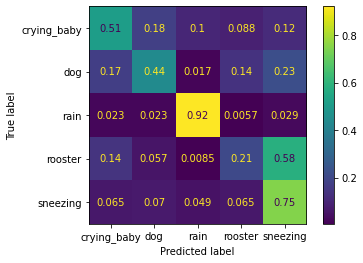

---

# **Getting to know Tensorflow for Neural Networks**
# 9. Import Tensorflow modules

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

---

# 10. One-Hot Encoding (OHE) of targets (binary class matrix)

Situation in our dataset:
* We have 5 classes, and only 1 class is always active --> This is a **multi-class** problem.
* Thus, we **categorize** our targets. A OHE'd target with index "3" becomes [0 0 0 1 0] (mapped against the output).
* https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [ ]:
print(f"y_train_ready.shape: {y_train_ready.shape}, y_test_ready.shape: {y_test_ready.shape}")  # These are our shapes so far.

### START CODING HERE ###
y_train_ready_OHE = to_categorical(y=..., num_classes=...)
y_test_ready_OHE = ....

print(f"y_train_ready_OHE.shape: {...}, y_test_ready_OHE.shape: {...}")  # These are our new shapes.
### END CODING HERE ###

Expected output:
```
y_train_ready.shape: (34560,), y_test_ready.shape: (8640,)
y_train_ready_OHE.shape: (34560, 5), y_test_ready_OHE.shape: (8640, 5)
```

---
# 11. Build a simple DNN (Sequential API & Functional API)

* Building an NN can be straightforward. Let's build a simple, extendable
architecture.
* Training and evaluating an NN is very similar to what you saw for the kNN-classifier.
* Sequential API: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
* Functional API: https://machinelearningmastery.com/keras-functional-api-deep-learning/

In [ ]:
# Sequential API
model_seq = Sequential()
model_seq.add(Dense(128, input_dim=128))       # input layer, 128 input features due to our feature extraction process (Dense == Fully Connected)
model_seq.add(Dense(256, activation="relu"))   # hidden layer 1
model_seq.add(Dense(64, activation="relu"))    # hidden layer 2
model_seq.add(Dense(5, activation="softmax"))  # output layer. Often this is sigmoid (each index can be between 0 and 1), or softmax (all indices sum up to 1)

# Functional API (node-like)
model_func_in = Input(shape=(128,))                               # input layer
model_func_x = Dense(10, activation="relu")(model_func_in)        # hidden layer 1
model_func_x = Dense(10, activation="relu")(model_func_x)         # hidden layer 2
model_func_x = Dense(10, activation="relu")(model_func_x)         # hidden layer 3
model_func_out = Dense(5, activation="softmax")(model_func_x)     # output layer
model_func = Model(inputs=model_func_in, outputs=model_func_out)  # model instance, specified with input and output layers

In [ ]:
# To simplify the following cells, select a desired model here
model = model_seq
#model = model_func

model.compile(optimizer=SGD(lr=0.001), loss=CategoricalCrossentropy(), metrics=["accuracy"])  # Compiles the model
# -> Given this loss function, "accuracy" means "Categorical Accuracy". Notice how "Categorical" relates to OHE

model.summary()  # Prints the architecture

Semi-expected output (depends on the selected model and its architecture):
```
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
=================================================================
Total params: 66,309
Trainable params: 66,309
Non-trainable params: 0
```

Now, **train** the model on the **train set** with the **OHE targets** for 10 epochs.


In [ ]:
### START CODING HERE ###
model...(x=..., y=..., epochs=10)
### END CODING HERE ###

Semi-expected output (loss and accuracy values will vary):
```
Epoch 1/10
1080/1080 [==============================] - 3s 2ms/step - loss: 1.4017 - accuracy: 0.4617
...
Epoch 9/10
1080/1080 [==============================] - 2s 2ms/step - loss: 1.0937 - accuracy: 0.5282
Epoch 10/10
1080/1080 [==============================] - 2s 2ms/step - loss: 1.0803 - accuracy: 0.5304
<keras.callbacks.History at 0x7fd1e1c21f90>
```

Now, **evaluate** the model on the **test set** and print the scores.

In [ ]:
### START CODING HERE ###
score = model...(x=..., y=..., return_dict=True, verbose=1)
print(f"Scores: ...")
### END CODING HERE ###

Semi-expected output (loss and accuracy values will vary):
```
270/270 [==============================] - 0s 1ms/step - loss: 1.1512 - accuracy: 0.4878
Scores: {'loss': 1.1512354612350464, 'accuracy': 0.4878472089767456}
```

Finally, we would like to see the confusion matrix for this model.
* Use the **predict**-function to classify the **test set**. This will give us "predicted targets".
* Because the targets & predictions are vectors (remember OHE), we need their **argmax** along a certain axis.
 * argmax retrieves the index at which the array contains the highest value.

In [ ]:
### START CODING HERE ###
# Predict the test set
predictions = model...(...)
print(f"Shape of predictions: {...}")

# Plot confusion matrix
confmat = confusion_matrix(y_true=..., y_pred=..., normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=..., display_labels=...)
disp.plot(xticks_rotation=45)  # rotate labels on x-axis for readability
...show()
### END CODING HERE ###

Expected output:
```
Shape of predictions: (8640, 5)
[a coloured confusion matrix]
```

---
# 12. Build a simple CNN (Functional API)

* Convolutional NNs are powerful NNs with large tuneable variety.
* Feel free to adjust number of filters and kernel sizes. But careful: The output may shrink by doing so!
* In the model summary, observe what happens with after each layer.

**NOTE:** We build the model first. More explanations are in the cell after.

In [ ]:
# Input layer
model_cnn_in = Input(shape=(1, 128, 1))  # Why 3 dims here...? "num_examples" can be left "unknown". Note "(None)" in the summary. (See next cell for more info.)

# Hidden layers
model_cnn_conv1 = Conv2D(filters=32, kernel_size=(1, 3), activation="relu")(model_cnn_in)  # Input is a vector (1, 128), so (1, 3) spans the kernel only over the feature dimension
model_cnn_pool1 = MaxPooling2D(pool_size=(1, 2))(model_cnn_conv1)  # Same as above: We pool only in frequency dimension
model_cnn_conv2 = Conv2D(filters=64, kernel_size=(1, 3), activation="relu")(model_cnn_pool1)
model_cnn_pool2 = MaxPooling2D(pool_size=(1, 2))(model_cnn_conv2)
model_cnn_conv2 = Conv2D(filters=128, kernel_size=(1, 3), activation="relu")(model_cnn_pool2)

# Towards backend
model_cnn_flat = Flatten()(model_cnn_conv2)
model_cnn_drop1 = Dropout(0.2)(model_cnn_flat)
model_cnn_dense1 = Dense(64, activation="relu")(model_cnn_drop1)

# Output layer
model_cnn_out = Dense(5, activation="softmax")(model_cnn_dense1)

# Actual model creation
model_cnn = Model(inputs=model_cnn_in, outputs=model_cnn_out)
model_cnn.compile(optimizer=SGD(lr=0.1), loss=CategoricalCrossentropy(), metrics=["accuracy"])
model_cnn.summary()

Expected output:
```
[CNN model architecture]
```

**CNN: Preparation of tensors**
* For 2D convolutional layers, we need to reshape our tensors.
* 2D conv layers take a 4D-input of the form NHWC: *(num_examples, height, width, channels)*.
  * **num_examples**: (in this case) total number of frames, here: 34560 (for the train set)
  * **height**: number of time frames per example, here: 1
  * **width**: feature dimension, here: 128
  * **channels**: audio channels, here: 1 (mono)

**IMPORTANT NOTES:**
* Above numbers are valid for our frame-based approach.
We could also translate *num_examples* to number of files, then each example would have a *height* of 216 (because each file has 216 frames).
* In our particular example, we could also use 1D conv layers with, e.g., kernel_size=(3). Same for MaxPooling.

In [ ]:
# Convert tensors to correct input shape (for both training and test sets)
print(f"Shapes: X_train_ready {X_train_ready.shape}, y_train_ready_OHE {y_train_ready_OHE.shape}")
# Shape X_train_ready: (34560, 128)    <-- needs format adjustment
# Shape y_train_ready_OHE: (34560, 5)  <-- already in correct format

# potentially: feed more "height" (time) in by switching dimensions to (1, 34560, 128, 1), then slicing the tensor into 160 tensors (with 216 frames each, essentially per-file training then)

### START CODING HERE ###
# Add channel dimension
X_train_cnn = np.expand_dims(X_train_ready, axis=-1)  # (34560, 128, 1)
X_test_cnn = ...                                      # (8640, 128, 1)

# Add height dimension
X_train_cnn = ...(X_train_cnn, axis=...)  # (34560, 1, 128, 1)
X_test_cnn = ...                          # (8640, 1, 128, 1)

# New shapes
print(f"Final shapes: X_train_cnn {...}, X_test_cnn {...}")
### END CODING HERE ###

Expected output:
```
Shapes: X_train_ready (34560, 128), y_train_ready_OHE (34560, 5)
Final shapes: X_train_cnn (34560, 1, 128, 1), X_test_cnn (8640, 1, 128, 1)
```

**Train** the CNN on the correct tensors for 10 epochs with a batch size of 16.

In [ ]:
### START CODING HERE ###
model_cnn...(x=..., y=..., batch_size=16, epochs=10)
### END CODING HERE ###

Semi-expected output:
```
Epoch 1/10
2160/2160 [==============================] - 47s 21ms/step - loss: 1.0592 - accuracy: 0.5251
...
Epoch 9/10
2160/2160 [==============================] - 47s 22ms/step - loss: 0.7470 - accuracy: 0.6611
Epoch 10/10
2160/2160 [==============================] - 46s 21ms/step - loss: 0.7371 - accuracy: 0.6646
<keras.callbacks.History at 0x7fd1ecc0de90>
```

**Evaluate** the CNN on the **test set** and print the scores.


In [ ]:
### START CODING HERE ###
scores = model_cnn...(..., return_dict=True, verbose=1)
print(f"Scores: ...")
### END CODING HERE ###

Semi-expected output:
```
270/270 [==============================] - 1s 5ms/step - loss: 1.0290 - accuracy: 0.5950
Scores: {'loss': 1.0289990901947021, 'accuracy': 0.5950231552124023}
```

**Confusion matrix**: Get the predictions for the **test set**, then consider the **argmax** again.

In [ ]:
### START CODING HERE ####
# Predict test set
predictions = model_cnn...(...)
print(f"Shape of predictions: {...}")

# Plot confusion matrix
confmat = confusion_matrix(y_true=..., y_pred=, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=..., display_labels=...)
disp.plot(xticks_rotation=45)
...show()  # display plot
### END CODING HERE ###

Expected output:

```
Shape of predictions: (8640, 5)
[a coloured confusion matrix]
```

---

# 13. Hyper-parameter tuning

Try playing around with these values and see how it affects the results:

* **learning rate**: go in steps of an order of (half) magnitude, e.g. 1.0, 0.1, 0.01, 0.005...
* **batch size**: e.g. 1, 16, 32, 216. 216 will result in 160 batches. Where have you seen this number before?